# Модель 4 (SqueezeNet + Conv2D)

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Аугментация (4)

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [3]:
train_ds, val_ds, test_ds = get_ds(
    'repaired_data_train', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [4]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

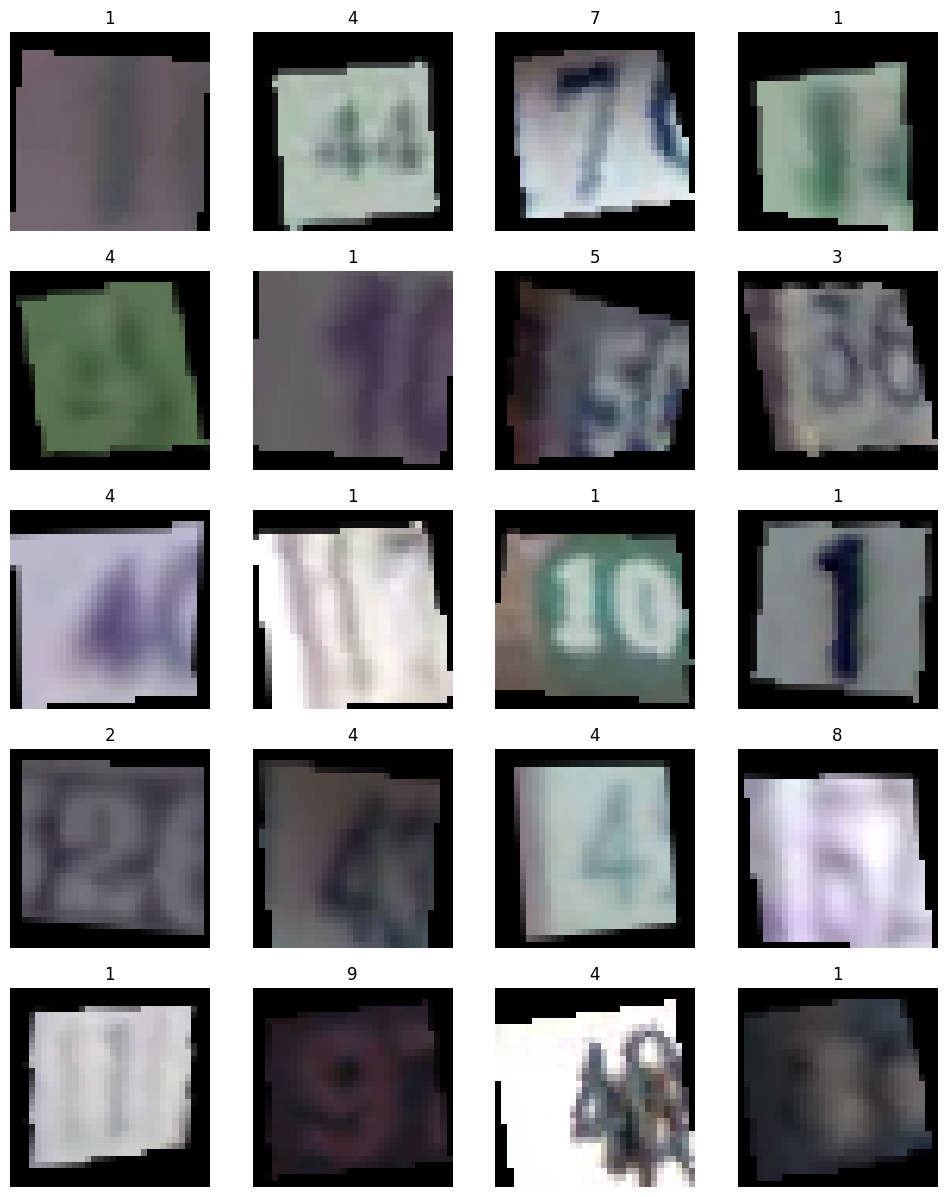

In [5]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель
![-](data/squeeze_block.jpg)

Разбор - https://youtu.be/KrEKm8doyRY?t=16

In [10]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(50, (3, 3), padding='same')(inputs)
x = tf.keras.layers.MaxPool2D(2)(x)

fork = tf.keras.layers.Conv2D(32, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(32, (1, 1))(fork)
branch2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])
x = tf.keras.layers.AveragePooling2D(2)(x)

fork = tf.keras.layers.Conv2D(64, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(64, (1, 1))(fork)
branch2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])
x = tf.keras.layers.MaxPool2D(2)(x)

x = tf.keras.layers.Conv2DTranspose(128, 4)(x)

fork = tf.keras.layers.Conv2D(256, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(256, (1, 1))(fork)
branch2 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])
x = tf.keras.layers.AveragePooling2D(2, padding='same')(x)

fork = tf.keras.layers.Conv2D(512, (1, 1))(x)
branch1 = tf.keras.layers.Conv2D(512, (1, 1))(fork)
branch2 = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])

x = tf.keras.layers.GlobalMaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 50)   1400        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 50)  0           ['conv2d_13[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 16, 16, 32)   1632        ['max_pooling2d_2[0][0]']        
                                                                                            

#### Создаем чекпоинты

In [5]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_g_5'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [12]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

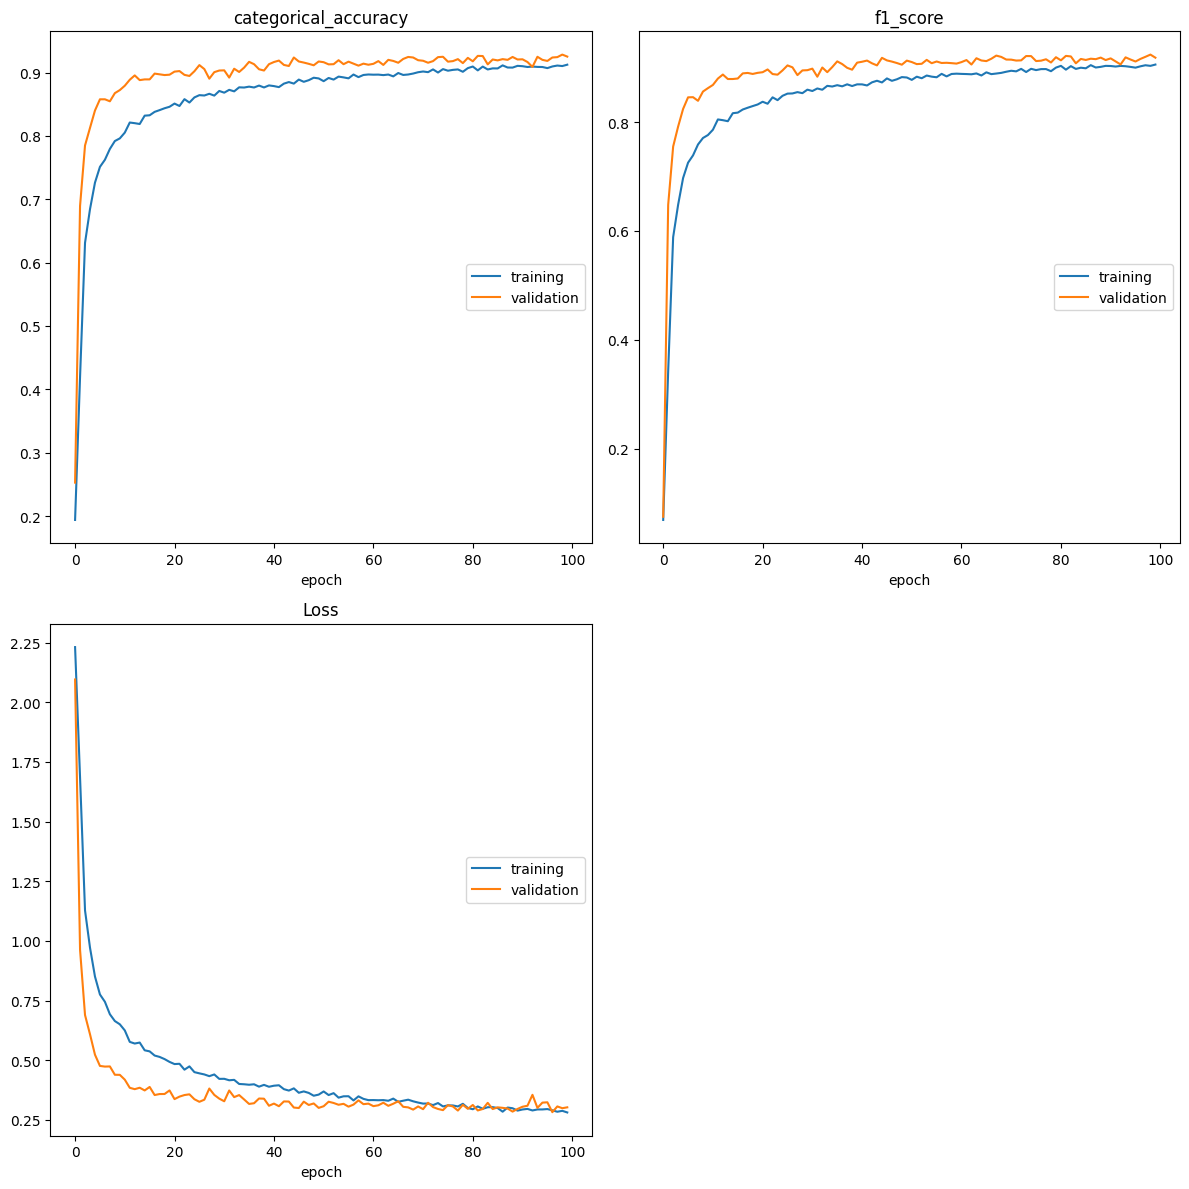

categorical_accuracy
	training         	 (min:    0.194, max:    0.912, cur:    0.912)
	validation       	 (min:    0.253, max:    0.928, cur:    0.925)
f1_score
	training         	 (min:    0.069, max:    0.906, cur:    0.906)
	validation       	 (min:    0.075, max:    0.924, cur:    0.919)
Loss
	training         	 (min:    0.281, max:    2.231, cur:    0.281)
	validation       	 (min:    0.282, max:    2.095, cur:    0.302)
91/91 [==============================] - 168s 2s/step - loss: 0.2809 - categorical_accuracy: 0.9124 - f1_score: 0.9060 - val_loss: 0.3023 - val_categorical_accuracy: 0.9252 - val_f1_score: 0.9186


In [13]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [6]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [7]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy, ans_val_avg_f1_score, ans_val_avg_loss]

110/110 [==============================] - 10s 92ms/step


Формируем валидационные ответы.

In [8]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [9]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


## ВЫВОД:

In [11]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [12]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,253,3225,9,14
1,636,2817,36,12
2,549,2920,22,10
3,398,3069,7,27
4,370,3108,8,15
5,277,3206,8,10
6,230,3235,17,19
7,258,3220,8,15
8,209,3246,26,20


{'accuracy': 0.9574407312196516,
 'precision': 0.9553046541280115,
 'recall': 0.9516131614973984,
 'f1_score': 0.9533090043945964}

...

### Loss чекпоинт

In [13]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,242,3231,3,25
1,635,2825,28,13
2,547,2927,15,12
3,399,3059,17,26
4,378,3101,15,7
5,274,3199,15,13
6,232,3235,17,17
7,260,3222,6,13
8,214,3255,17,15


{'accuracy': 0.9574407312196516,
 'precision': 0.9537911941055615,
 'recall': 0.9514096890773358,
 'f1_score': 0.9523272127653785}

...

### F1-score чекпоинт

In [14]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,253,3225,9,14
1,636,2817,36,12
2,549,2920,22,10
3,398,3069,7,27
4,370,3108,8,15
5,277,3206,8,10
6,230,3235,17,19
7,258,3220,8,15
8,209,3246,26,20


{'accuracy': 0.9574407312196516,
 'precision': 0.9553046541280115,
 'recall': 0.9516131614973984,
 'f1_score': 0.9533090043945964}

...

In [16]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,255,3229,5,12
1,637,2832,21,11
2,553,2933,9,6
3,411,3065,11,14
4,379,3108,8,6
5,278,3210,4,9
6,242,3241,11,7
7,267,3220,8,6
8,218,3266,6,11


{'accuracy': 0.9748643244787204,
 'precision': 0.9744472747890782,
 'recall': 0.9715817982119301,
 'f1_score': 0.9729617036973535}

In [17]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,257,3230,4,10
1,637,2835,18,11
2,552,2935,7,7
3,412,3057,19,13
4,379,3109,7,6
5,272,3208,6,15
6,239,3240,12,10
7,268,3221,7,5
8,219,3262,10,10


{'accuracy': 0.9734361610968295,
 'precision': 0.9726893189379837,
 'recall': 0.9698948351008283,
 'f1_score': 0.9712375572058043}

- Сохраняем ответы.

In [18]:
# ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds, f'../answers/model{num_model}_categorical_accuracy.csv')
# ans_test_f1_score = make_ans_file(model_f1_score, test_ds, f'../answers/model{num_model}_f1_score.csv')
# ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds, f'../answers/model{num_model}_avg_categorical_accuracy.csv')
# ans_test_avg_f1_score = make_ans_file(model_avg_f1_score, test_ds, f'../answers/model{num_model}_avg_f1_score.csv')
# ans_test_avg_loss = make_ans_file(model_avg_loss, test_ds, f'../answers/model{num_model}_avg_loss.csv')
# anss = [ans_test_categorical_accuracy, ans_test_f1_score, ans_test_avg_categorical_accuracy, ans_test_avg_f1_score]

782/782 [==============================] - 73s 93ms/step
